**Final Panel regression**

In [89]:
import os
import numpy as np
import pandas as pd
import xarray as xr

**Tweet data**

Merge single county files at daily resolution into 1 big data frame

In [90]:
in_dir = "/Volumes/Extreme/100/Counties_Resampled_Felix"
in_flist = os.listdir(in_dir)

container = []
# here, on the very top we would have a loop over the raw files:
for fname in in_flist:
    fips = fname.split(".")[0]
    fpath = os.path.join(in_dir, fname)
    df = pd.read_pickle(fpath)
    df["FIPS"] = np.repeat(fips, len(df))
    container.append(df)

In [101]:
df_merged = pd.concat(container, axis=0)
df_merged["date"] = df_merged.index.values
df_merged = df_merged.set_index(['FIPS','date'])
df_merged.index = df_merged.index.set_names(["county", "time"])
df_tweets = df_merged.copy()

**CSSE data**

In [154]:
fpath_csse = "/Users/felix/ETH/code/bdproject/data/processed/csse/US/csse_data_merged.nc"
ds = xr.open_dataset(fpath_csse)
df = ds.to_dataframe()

# calculate time derivatives
df['confirmed_d1'] = np.gradient(df['confirmed'].values)
df['deaths_d1'] = np.gradient(df['deaths'].values)

df['confirmed_d2'] = np.gradient(df['confirmed_d1'].values)
df['deaths_d2'] = np.gradient(df['deaths_d1'].values)

confirmed  deaths  confirmed_d1  deaths_d1  confirmed_d2  \
county time                                                                   
60     2020-01-22          0       0           0.0        0.0           0.0   
       2020-01-23          0       0           0.0        0.0           0.0   
       2020-01-24          0       0           0.0        0.0           0.0   
       2020-01-25          0       0           0.0        0.0           0.0   
       2020-01-26          0       0           0.0        0.0           0.0   
...                      ...     ...           ...        ...           ...   
99999  2020-07-17        103       3           0.0        0.0           0.0   
       2020-07-18        103       3           0.0        0.0           0.0   
       2020-07-19        103       3           0.0        0.0           0.0   
       2020-07-20        103       3           0.0        0.0           0.0   
       2020-07-21        103       3           0.0        0.0           0.0   

                   deaths_d2  
county time                   
60     2020-01-22        0.0  
       2020-01-23        0.0  
       2020-01-24        0.0  
       2020-01-25        0.0  
       2020-01-26        0.0  
...                      ...  
99999  2020-07-17        0.0  
       2020-07-18        0.0  
       2020-07-19        0.0  
       2020-07-20        0.0  
       2020-07-21        0.0  

[606060 rows x 6 columns]

In [155]:
def pad_fips(row):
    return '{0:05d}'.format(row)

fips = pd.Series(df.index.get_level_values("county").values)
new_idx = fips.apply(pad_fips).unique()
df_csse = df.copy()
df_csse.index = df_csse.index.set_levels(new_idx, level=0)

In [157]:
df_tweets = df_tweets.sort_index()
df_csse = df_csse.sort_index()

confirmed  deaths  confirmed_d1  deaths_d1  confirmed_d2  \
county time                                                                   
00060  2020-01-22          0       0           0.0        0.0           0.0   
       2020-01-23          0       0           0.0        0.0           0.0   
       2020-01-24          0       0           0.0        0.0           0.0   
       2020-01-25          0       0           0.0        0.0           0.0   
       2020-01-26          0       0           0.0        0.0           0.0   
...                      ...     ...           ...        ...           ...   
99999  2020-07-17        103       3           0.0        0.0           0.0   
       2020-07-18        103       3           0.0        0.0           0.0   
       2020-07-19        103       3           0.0        0.0           0.0   
       2020-07-20        103       3           0.0        0.0           0.0   
       2020-07-21        103       3           0.0        0.0           0.0   

                   deaths_d2  
county time                   
00060  2020-01-22        0.0  
       2020-01-23        0.0  
       2020-01-24        0.0  
       2020-01-25        0.0  
       2020-01-26        0.0  
...                      ...  
99999  2020-07-17        0.0  
       2020-07-18        0.0  
       2020-07-19        0.0  
       2020-07-20        0.0  
       2020-07-21        0.0  

[606060 rows x 6 columns]

**Merge the two data frames**

In [186]:
panel = df_tweets.merge(df_csse, left_index=True, right_on=['county', 'time'])
panel.to_pickle("data/panels/panel.pkl")
panel.columns

Index(['polarity_0.0', 'polarity_0.025', 'polarity_0.25', 'polarity_0.5',
       'polarity_0.75', 'polarity_0.095', 'polarity_1.0', 'polarity_mean',
       'polarity_sd', 'subjectivity_0.0', 'subjectivity_0.025',
       'subjectivity_0.25', 'subjectivity_0.5', 'subjectivity_0.75',
       'subjectivity_0.095', 'subjectivity_1.0', 'subjectivity_mean',
       'subjectivity_sd', 'positive_0.0', 'positive_0.025', 'positive_0.25',
       'positive_0.5', 'positive_0.75', 'positive_0.095', 'positive_1.0',
       'positive_mean', 'positive_sd', 'negative_0.0', 'negative_0.025',
       'negative_0.25', 'negative_0.5', 'negative_0.75', 'negative_0.095',
       'negative_1.0', 'negative_mean', 'negative_sd', 'neutral_0.0',
       'neutral_0.025', 'neutral_0.25', 'neutral_0.5', 'neutral_0.75',
       'neutral_0.095', 'neutral_1.0', 'neutral_mean', 'neutral_sd',
       'retweets_total', 'confirmed', 'deaths', 'confirmed_d1', 'deaths_d1',
       'confirmed_d2', 'deaths_d2'],
      dtype='object')

**Correlation analysis**

In [178]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_matrix(df):
    """
    Given a pd.DataFrame, calculate Pearson's R
    and the p-values of the correlation.
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing numeric values.
    Returns
    -------
    (correlations, p_values) : tuple
        Tuple of dataframes.
    """
    df = df.dropna(axis=0)._get_numeric_data()
    cols = pd.DataFrame(columns=df.columns)

    correlations = cols.transpose().join(cols, how='outer')
    p_values = cols.transpose().join(cols, how='outer')

    for r in df.columns:
        for c in df.columns:
            # pearsonr returns a tuple like (corr, pval)
            correlations[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            p_values[r][c] = round(pearsonr(df[r], df[c])[1], 4)

    return (correlations.apply(pd.to_numeric),
            p_values.apply(pd.to_numeric))

def correlation_matrix_plot(df, significance_level=0.1, cbar_levels=8, 
                            figsize=(6,6), fontsize=10, title="", ax=None):
    """Plot corrmat considering p-vals."""
    corr, pvals = correlation_matrix(df)

    # create triangular mask for heatmap
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # mask corrs based on p-values
    pvals_plot = np.where(pvals > significance_level, "x", round(corr, 4))

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr,
                mask=mask,
                cmap=sns.diverging_palette(20, 220, n=cbar_levels),
                square=True,
                vmin=-1,
                center=0,
                vmax=1,
                annot=pvals_plot,
                fmt="",  # default: fmt='.2g'
                cbar_kws={"fraction": 0.046, "pad": 0.04},
                annot_kws={"fontsize": fontsize},
                ax=ax)
    ax.set_title(title + " (p < {:.2f})".format(significance_level))
    if ax is None:
        plt.tight_layout()
    return ax

def lag_features(df, n_lags=1):
    "Calculate lagged features of input series."
    df_lagged = df.copy()

    for lag in range(1, n_lags + 1):
        shifted = df.shift(lag)
        shifted.columns = [x + "_lag" + str(lag) for x in df.columns]

        df_lagged = pd.concat((df_lagged, shifted), axis=1)
    return df_lagged

In [182]:
panel.columns

Index(['polarity_0.0', 'polarity_0.025', 'polarity_0.25', 'polarity_0.5',
       'polarity_0.75', 'polarity_0.095', 'polarity_1.0', 'polarity_mean',
       'polarity_sd', 'subjectivity_0.0', 'subjectivity_0.025',
       'subjectivity_0.25', 'subjectivity_0.5', 'subjectivity_0.75',
       'subjectivity_0.095', 'subjectivity_1.0', 'subjectivity_mean',
       'subjectivity_sd', 'positive_0.0', 'positive_0.025', 'positive_0.25',
       'positive_0.5', 'positive_0.75', 'positive_0.095', 'positive_1.0',
       'positive_mean', 'positive_sd', 'negative_0.0', 'negative_0.025',
       'negative_0.25', 'negative_0.5', 'negative_0.75', 'negative_0.095',
       'negative_1.0', 'negative_mean', 'negative_sd', 'neutral_0.0',
       'neutral_0.025', 'neutral_0.25', 'neutral_0.5', 'neutral_0.75',
       'neutral_0.095', 'neutral_1.0', 'neutral_mean', 'neutral_sd',
       'retweets_total', 'confirmed', 'deaths', 'confirmed_d1', 'deaths_d1',
       'confirmed_d2', 'deaths_d2'],
      dtype='object')

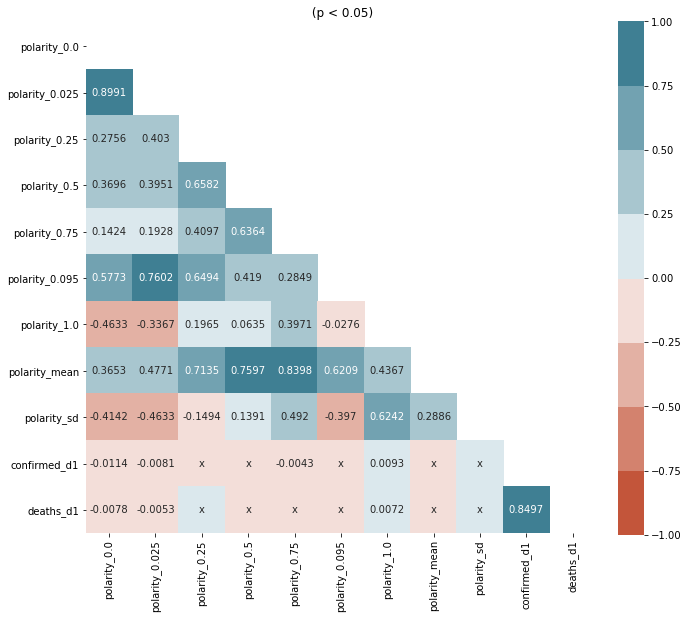

In [185]:
panel_subset = panel[['polarity_0.0', 'polarity_0.025', 'polarity_0.25', 'polarity_0.5',
       'polarity_0.75', 'polarity_0.095', 'polarity_1.0', 'polarity_mean',
       'polarity_sd', "confirmed_d1", "deaths_d1"]]
#panel_subset_lagged = lag_features(panel_subset, 3)
correlation_matrix_plot(panel_subset, figsize=(10,10), significance_level=0.05)

**Panel regression**

In [166]:
# run panel regression with Entity and Time FE's
from linearmodels import PanelOLS

mod = PanelOLS.from_formula('polarity_mean ~ confirmed_d1 + confirmed_d2 + deaths_d1 + deaths_d2 + EntityEffects + TimeEffects', panel)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          polarity_mean   R-squared:                     1.355e-05
Estimator:                   PanelOLS   R-squared (Between):           7.722e-05
No. Observations:              293845   R-squared (Within):            1.266e-05
Date:                Wed, Jul 22 2020   R-squared (Overall):           4.834e-05
Time:                        18:37:26   Log-likelihood                 1.796e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.9847
Entities:                        3014   P-value                           0.4143
Avg Obs:                       97.493   Distribution:                F(4,290696)
Min Obs:                       1.0000                                           
Max Obs:                       132.00   F-statistic (robust):             3.7085
                            